# Initial setup of project 

## Install Packages

In [ ]:
!pip install transformers==3.1.0
!pip install numpy
!pip install sklearn
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install seaborn


## Import Modules

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,plot_confusion_matrix
from transformers import AutoModel, BertTokenizerFast,AdamW,BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sn

## Setup global variables needed

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
looper = 10

# Importing pre-trained BERT model

* Using BERT based multilingual model to handle the different languages present in the dataset. It supports 104 languages.
* BERT Tokenizer converts sentences into small tokens of words and passes that to an encoder.
* Make Require_grad as false to avoid changes to original model

In [ ]:
bert = AutoModel.from_pretrained('bert-base-multilingual-cased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

`We don't want to make any changes to original bert model, hence we will set requires_grad to False. It will acts as a base model`

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

# Load Dataset

`Loading the dataset created. The datafiles have been combined into a single JSON file comprising of text and the corresponding meta data category.`
* Load data
* Factorize (convert categories/labels to incremental integers) catgeory column
* Convert text to lowercase (as we are using uncased bert model)
* Sampling the records
* Counting the total number of unique categories in the sampled dataset

In [ ]:
df = pd.read_json("sample_data.json")
df["category"] = pd.factorize(df.label)[0]
df["text"] = df["text"].str.lower()
df = df.sample(n=35000)
number_of_classes = len(df['label'].value_counts(normalize = True))

## Analysing dataset

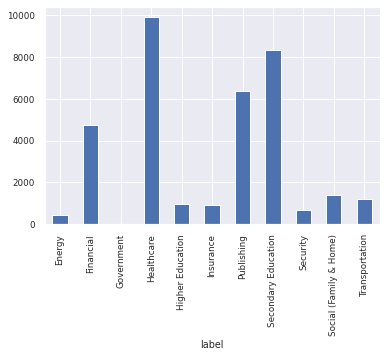

In [ ]:
df.head()
df.groupby("label")["text"].count().plot(kind="bar")
plt.show()

# Divide the dataset into training, testing and validation subsets

`Dividing the dataset into training and temporary datasets with a ratio of 70 and 30 respectively. Further the temporary dataset is divided into equal parts for testing and validation purposes.`

In [ ]:
training_data, temporary_data, training_category, temporary_category = train_test_split(df['text'], df['category'], 
                                                                    random_state=100, 
                                                                    test_size=0.3)

validation_data, test_data, validation_category, testing_category = train_test_split(temporary_data, temporary_category, 
                                                                random_state=100, 
                                                                test_size=0.5)

# Identifying the value of max_seq_length parameter for BERT

`Looking at the lenght of the sentences in the training data to decide the maximum length sequence to be used by BERT. This will be used by the model to create equal fixed sized tokens which will be used by the encoder.`

* Maximum sequence length has been calculated by taking the average length of all sentences plus a buffer of 20.

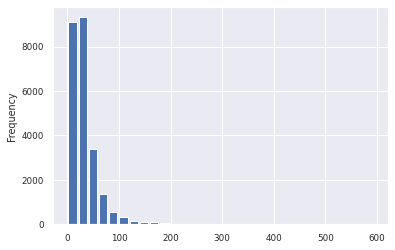

In [ ]:
sentence_length = [len(i.split()) for i in training_data]
pd.Series([len(i.split()) for i in training_data]).plot(kind="hist",bins = 30,rwidth=0.8)

max_seq_len = int(sum(sentence_length)/len(sentence_length)) + 20

# Tokenize the input dataset (Training, Validation, Test)

`Creating tokens and encoding them using BERT tokenizer for training, validation and testing datasets.`

In [ ]:
training_data_tokens = tokenizer.batch_encode_plus(
    training_data.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

testing_data_tokens = tokenizer.batch_encode_plus(
    test_data.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

validation_data_tokens = tokenizer.batch_encode_plus(
    validation_data.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)


# Generate multi-dimensional matrix containing elements of a single data type using Torch Tensor 

In [ ]:
training_sequence = torch.tensor(training_data_tokens['input_ids'])
training_maskings = torch.tensor(training_data_tokens['attention_mask'])
training_cat = torch.tensor(training_category.tolist())

validation_sequence = torch.tensor(validation_data_tokens['input_ids'])
validation_masks = torch.tensor(validation_data_tokens['attention_mask'])
validation_cat = torch.tensor(validation_category.tolist())

testing_sequence = torch.tensor(testing_data_tokens['input_ids'])
testing_masks = torch.tensor(testing_data_tokens['attention_mask'])
testing_cat = torch.tensor(testing_category.tolist())

# Create DataLoaders

In [ ]:
 # wrap tensors
train_data = TensorDataset(training_sequence, training_maskings, training_cat)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(validation_sequence, validation_masks, validation_cat)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Define Model Custom class

In [ ]:
class BertModelCustomClass(nn.Module):

    def __init__(self, bert):
      
      super(BertModelCustomClass, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,number_of_classes)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

# Create Model
* Pass BERT pretrained model to custom Class (BertModelCustomClass)
* Push Model to GPU
* Create Optimizer for model using AdamW

In [ ]:
model = BertModelCustomClass(bert)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Initiliaze weights and convert it into Multi Dimensional matrix array.

In [ ]:
class_wts = compute_class_weight('balanced', np.unique(training_category), training_category)
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights) 

# Create Training and Evaluation steps

In [ ]:
class Modeler():
  def train(self):
    model.train()
    total_loss=0
    total_preds=[]
    
    # iterate over batches
    for _,batch in enumerate(train_dataloader):
      # push the batch to gpu
      batch = [r.to(device) for r in batch]
      sent_id, mask, labels = batch
      model.zero_grad()        
      preds = model(sent_id, mask)
      loss = cross_entropy(preds, labels)

      # add on to the total loss
      total_loss = total_loss + loss.item()

      # backward pass to calculate the gradients
      loss.backward()

      # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # update parameters
      optimizer.step()

      # model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      # append the model predictions
      total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss

  # function for evaluating the model
  def evaluate(self):
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for _,batch in enumerate(val_dataloader):
    
      # push the batch to gpu
      batch = [t.to(device) for t in batch]

      sent_id, mask, labels = batch

      # deactivate autograd
      with torch.no_grad():
        
        # model predictions
        preds = model(sent_id, mask)

        # compute the validation loss between actual and predicted values
        loss = cross_entropy(preds,labels)

        total_loss = total_loss + loss.item()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss

# Start Model Training

In [ ]:
temp = float('inf')
trainer=Modeler();
#for each epoch
for i in range(looper):
     
    print(f'Loop {i+1} out of {looper}')
    
    #train model
    training_loss = trainer.train()
    validation_loss = trainer.evaluate()
    
    #save the best model
    if validation_loss < temp:
        temp = validation_loss
        torch.save(model.state_dict(), 'trained_model.model')
    
    print(f'Training Loss: {training_loss:.3f}')
    print(f'Validation Loss: {validation_loss:.3f}\n\n')

Loop 1 out of 10
Training Loss: 1.789
Validation Loss: 1.375


Loop 2 out of 10
Training Loss: 1.463
Validation Loss: 1.310


Loop 3 out of 10
Training Loss: 1.369
Validation Loss: 1.184


Loop 4 out of 10
Training Loss: 1.306
Validation Loss: 1.106


Loop 5 out of 10
Training Loss: 1.260
Validation Loss: 1.213


Loop 6 out of 10
Training Loss: 1.229
Validation Loss: 1.041


Loop 7 out of 10
Training Loss: 1.192
Validation Loss: 1.001


Loop 8 out of 10
Training Loss: 1.178
Validation Loss: 0.947


Loop 9 out of 10
Training Loss: 1.162
Validation Loss: 1.012


Loop 10 out of 10
Training Loss: 1.142
Validation Loss: 0.945




# Predict

## Load Model

In [ ]:
path = 'trained_model.model'
torch.load(path,map_location=torch.device(device))
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Predict for test data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(testing_sequence.to(device), testing_masks.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

## Analyse prediction

In [ ]:
report = classification_report(testing_cat, preds,target_names=df.label.unique())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_classification_report(cr, cmap=plt.cm.Blues):
    print(cr)
    lines = cr.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        if(len(t)>3):
          t.reverse()
          plotMat.append([float(t[2]),float(t[1]),float(t[0])])
          cls=t[4:]
          cls.reverse()
          classes.append(' '.join(cls))
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, origin="lower")
    plt.title('Classification report')
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
def plot_confusion_report(cr):
  print(cr)
  df_cm = pd.DataFrame(cr, range(number_of_classes-1), range(number_of_classes-1))
  sn.set(font_scale=0.8)
  fig = plt.figure(figsize=(10, 10))
  sn.heatmap(df_cm, annot=True, fmt='.3g', annot_kws={"size": 13}) # font size
  plt.show()


                        precision    recall  f1-score   support

   Secondary Education       0.83      0.73      0.78       988
            Publishing       0.79      0.53      0.64      1191
Social (Family & Home)       0.80      0.58      0.67       798
              Security       0.23      0.66      0.34       129
            Healthcare       0.95      0.92      0.94       560
        Transportation       0.58      0.97      0.72       158
             Financial       0.46      0.21      0.29        87
             Insurance       0.68      0.95      0.79       125
                Energy       0.15      0.78      0.25        55
      Higher Education       0.13      0.35      0.19       106
            Government       0.00      0.00      0.00         3

              accuracy                           0.66      4200
             macro avg       0.51      0.61      0.51      4200
          weighted avg       0.76      0.66      0.69      4200



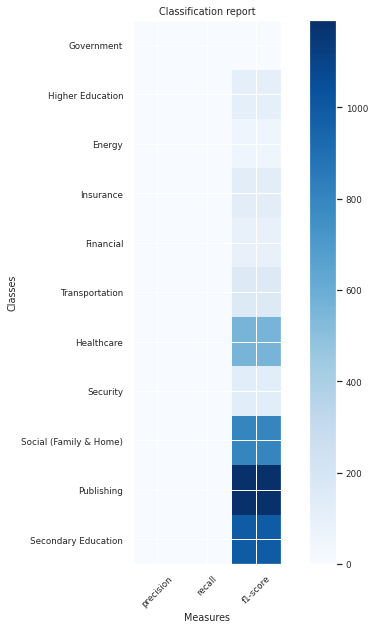

In [ ]:
plot_classification_report(report)

col_0    0    1    2    3    4    5   6    7    8   9
row_0                                                
0      717   74   55   36    1    1   1    5   43  55
1       91  635   42  145    9   65  11   21  102  70
2       37   58  462   35   11   26   4   13   59  93
3        3    8    5   85    3    4   1    1   15   4
4        0   11    0   14  517    2   1    8    0   7
5        0    2    0    1    0  154   0    1    0   0
6        1    5    1   35    1    4  18    7   12   3
7        0    2    0    2    0    1   0  119    0   1
8        2    3    0    4    0    0   0    0   43   3
9        7    8   14   15    2   10   3    1    9  37
10       1    0    0    0    0    0   0    0    0   2


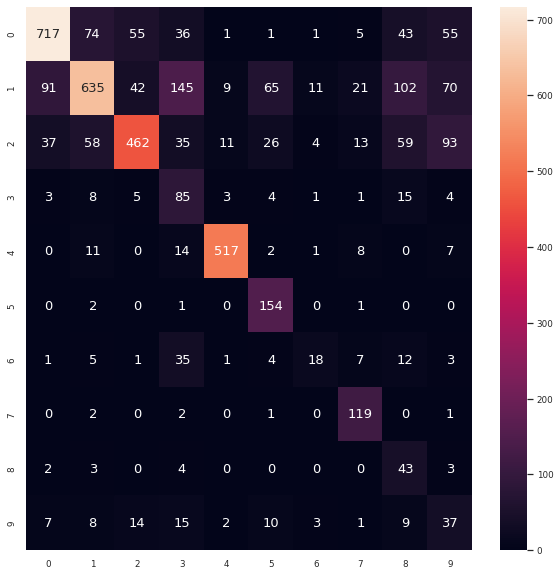

In [ ]:
plot_confusion_report(pd.crosstab(testing_cat, preds))